# Flight Delays: Modeling

In [8]:
import pandas as pd
import glob
import os
import requests
import json
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from keras import regularizers
from keras import models
from keras import layers
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

import keras
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from scipy import stats
import pickle

### Importing Prepared Data

In the first notebook, we prepared our data by engineering extra features and cleaning up missing data. We now bring that data here.

In [9]:
carrier_data = pd.read_csv('data/prepared/data_for_modeling.csv')

In [10]:
# Preview what the data looks like
carrier_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4342575 entries, 0 to 4342574
Data columns (total 36 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   MONTH                        int64  
 1   DAY_OF_MONTH                 int64  
 2   DAY_OF_WEEK                  object 
 3   MKT_CARRIER                  object 
 4   ORIGIN                       object 
 5   DEST                         object 
 6   CRS_ELAPSED_TIME             float64
 7   DISTANCE                     float64
 8   origin-elevation             float64
 9   dest-elevation               float64
 10  takeoff-time-of-day          object 
 11  arrival-time-of-day          object 
 12  ARR_DAY_OF_WEEK              object 
 13  avg-takeoff-congestion       float64
 14  avg-arrival-congestion       float64
 15  dest-avg-takeoff-congestion  float64
 16  dest-avg-arrival-congestion  float64
 17  holiday                      object 
 18  days-from-specific-holiday   object 
 19  

In [11]:
pd.set_option('display.max_columns', 100)
carrier_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER,ORIGIN,DEST,CRS_ELAPSED_TIME,DISTANCE,origin-elevation,dest-elevation,takeoff-time-of-day,arrival-time-of-day,ARR_DAY_OF_WEEK,avg-takeoff-congestion,avg-arrival-congestion,dest-avg-takeoff-congestion,dest-avg-arrival-congestion,holiday,days-from-specific-holiday,takeoff-mins-from-midnight,landing-mins-from-midnight,target,maxtemp,mintemp,avgtemp,totalprecip,avgvis,maxwind,avghumidity,dest-maxtemp,dest-mintemp,dest-avgtemp,dest-totalprecip,dest-avgvis,dest-maxwind,dest-avghumidity
0,6,1,Tuesday,DL,LAS,MSP,186.0,1299.0,2181.0,841.0,Night,Early Morning,Tuesday,1.329932,1.209226,1.776888,1.383135,Not a Holiday,Memorial Day_1.0,15,321,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
1,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,2181.0,841.0,Early Morning,Late Morning,Tuesday,2.024347,1.501475,1.634171,1.296566,Not a Holiday,Memorial Day_1.0,370,673,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
2,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.684955,1.355537,Not a Holiday,Memorial Day_1.0,554,857,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
3,6,1,Tuesday,WN,LAS,MSP,185.0,1299.0,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.684955,1.355537,Not a Holiday,Memorial Day_1.0,630,935,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
4,6,1,Tuesday,DL,LAS,MSP,188.0,1299.0,2181.0,841.0,Late Morning,Late Afternoon,Tuesday,1.683796,1.420449,1.254342,1.393955,Not a Holiday,Memorial Day_1.0,701,1009,No,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0


In [12]:
for col in carrier_data.select_dtypes(exclude='number').columns:
    print(carrier_data[col].value_counts().sort_values())
    print('---------------')

Saturday     561881
Tuesday      612069
Wednesday    618178
Sunday       628655
Friday       635354
Monday       638130
Thursday     648308
Name: DAY_OF_WEEK, dtype: int64
---------------
NK     204140
B6     231420
AS     235776
UA     727929
AA     898842
DL     958598
WN    1085870
Name: MKT_CARRIER, dtype: int64
---------------
CVG     14068
MEM     14725
ANC     14837
CHS     15855
OKC     17358
        ...  
DFW    189286
ORD    194265
LAX    198719
DEN    239471
ATL    260395
Name: ORIGIN, Length: 62, dtype: int64
---------------
BTV      1005
DAB      1070
GRB      1117
STX      1135
ATW      1149
        ...  
DFW    146915
ORD    161150
DEN    172284
LAX    172328
ATL    198899
Name: DEST, Length: 170, dtype: int64
---------------
Night               162422
Late Evening        333896
Late Afternoon      505162
Early Evening       521471
Early Afternoon     751339
Early Morning       992413
Late Morning       1075872
Name: takeoff-time-of-day, dtype: int64
---------------
Earl

4 million records is also way too much for modeling. So we need to take a sample of our entire dataset.

In [13]:
carrier_data_sample = carrier_data.sample(frac=0.05, axis=0, random_state=123)
carrier_data_sample.to_csv('data/prepared/data_for_modeling_sample.csv', index=False)

In [10]:
carrier_data_sample = pd.read_csv('data/prepared/data_for_modeling_sample.csv')

### Splitting up data for training, validation & testing

In [14]:
# Splitting features & target
y = carrier_data_sample["target"]
X = carrier_data_sample.drop(["target"], axis=1)

# Creating train, test and validation sets

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [16]:
num_cols = ['CRS_ELAPSED_TIME',
'DISTANCE',
'origin-elevation',
'dest-elevation',
'avg-takeoff-congestion',
'avg-arrival-congestion',
'dest-avg-takeoff-congestion',
'dest-avg-arrival-congestion',
'takeoff-mins-from-midnight',
'landing-mins-from-midnight',
'maxtemp',
'mintemp',
'avgtemp',
'totalprecip',
'avgvis',
'maxwind',
'avghumidity',
'dest-maxtemp',
'dest-mintemp',
'dest-avgtemp',
'dest-totalprecip',
'dest-avgvis',
'dest-maxwind',
'dest-avghumidity']

cat_cols = ['MONTH',
'DAY_OF_MONTH',
'DAY_OF_WEEK',
'MKT_CARRIER',
'ORIGIN',
'DEST',
'takeoff-time-of-day',
'arrival-time-of-day',
'ARR_DAY_OF_WEEK',
'holiday',
'days-from-specific-holiday']

In [17]:
# Training Data
# X_train_num = X_train[num_cols].copy()
# X_train_cat = X_train[cat_cols].copy()

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_num)
# X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

# X_train_cat = X_train_cat.applymap(str)
# cols = X_train_cat.columns

# X_train_ohe = pd.get_dummies(X_train_cat,prefix=cols, drop_first=False)

# preprocessed_data = pd.concat([X_train_ohe, X_train_scaled], axis=1)

# n_features = preprocessed_data.shape[1]


t = [('cat', OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore"), cat_cols), ('num', StandardScaler(), num_cols)]
col_transform = ColumnTransformer(transformers=t)

# Test Data

# X_valid_num = X_valid[num_cols].copy()
# X_valid_cat = X_valid[cat_cols].copy()

# X_valid_scaled = scaler.transform(X_valid_num)
# X_valid_scaled = pd.DataFrame(X_valid_scaled, index=X_valid_num.index, columns=X_valid_num.columns)

# X_valid_cat = X_valid_cat.applymap(str)
# cols = X_valid_cat.columns
# X_valid_ohe = pd.get_dummies(X_valid_cat,prefix=cols, drop_first=False)

# preprocessed_val_data = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

In [18]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
# class weights dict

class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Class weight num dict
class_weights_num_dict = {0: class_weights_dict['No'],
                1: class_weights_dict['Yes']}

# Sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
valid_sample_weights = compute_sample_weight(class_weight='balanced', y=y_valid)

# Labels for deep learning
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)
valid_labels = binarizer.fit_transform(y_valid)

## Modeling

### Helper Functions

In [19]:
def visualize_training_results(hist):
   
    hist_dict = hist.history
    fig, ax = plt.subplots(figsize=(12, 8))

    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Validation loss')

    ax.set_title('Training & validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();
   
    fig, ax = plt.subplots(figsize=(12, 8))

    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc']

    ax.plot(epochs, acc_values, label='Training acc')
    ax.plot(epochs, val_acc_values, label='Validation acc')
    ax.set_title('Training & validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend();
   
def evaluate_model(model, x, y):
    """
    Describe the function -- inputs, expected output, what is model? what are x/y and expected formats
    """
    y_true = y
    
    if type(y).__module__ == np.__name__:
        predications = model.predict(x)
        l = x.shape[0] 
        y_pred = np.zeros((l, 1))
        for i in range(predications.shape[0]):
            if predications[i,0] > 0.5: 
                y_pred[i, 0] = 1
            else:
                y_pred[i, 0] = 0
        
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label=1)
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label=1)
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
        
    else:
        y_pred  = model.predict(x)
   
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label='Yes')
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label='Yes')
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label='Yes')
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')

### Gradient Descent

#### Logistic Regression

Model Scores for Validation Data:
--------------
Accuracy: 0.934
Precision: 0.000
Recall: 0.000


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.000
--------------
Confusion Matrix:


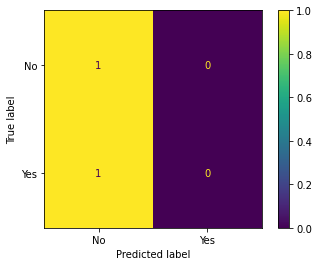

In [15]:
baselline_pipe = Pipeline(steps=[
    ('dc', DummyClassifier(strategy='most_frequent'))
])

baselline_pipe.fit(preprocessed_data, y_train)

evaluate_model(baselline_pipe, preprocessed_val_data, y_valid)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.933
Precision: 0.419
Recall: 0.001
F1 score: 0.002
--------------
Confusion Matrix:


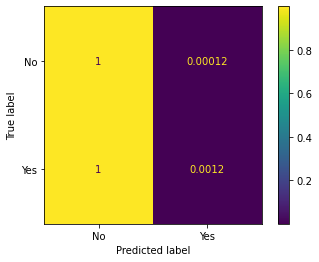

In [16]:
lr_pipe1 = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=123))
])

lr_pipe1.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe1, preprocessed_data, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.655
Precision: 0.122
Recall: 0.665
F1 score: 0.206
--------------
Confusion Matrix:


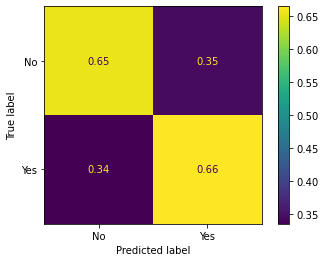

In [17]:
lr_pipe2 = Pipeline(steps=[
    ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))
])

lr_pipe2.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe2, preprocessed_data, y_train)

#### Random Forest

Model Scores for Validation Data:
--------------
Accuracy: 0.934
Precision: 0.000


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


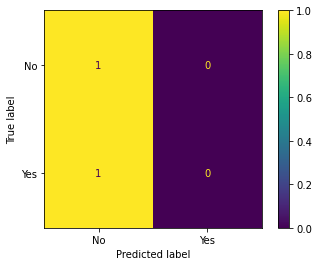

In [18]:
rf_pipe = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  random_state=123))
])

rf_pipe.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.769
Precision: 0.140
Recall: 0.483
F1 score: 0.217
--------------
Confusion Matrix:


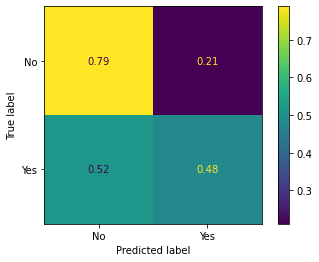

In [19]:
rf_pipe2 = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  class_weight=class_weights_dict,
                                  random_state=123))
])

rf_pipe2.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe2, preprocessed_val_data, y_valid)

#### XGBoost

Model Scores for Validation Data:
--------------
Accuracy: 0.745
Precision: 0.134
Recall: 0.516
F1 score: 0.212
--------------
Confusion Matrix:


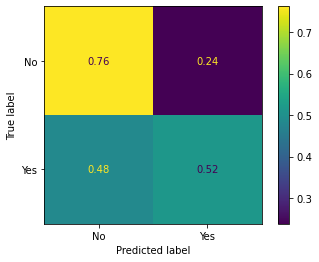

In [20]:
xgb_pipe = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe.fit(preprocessed_data, y_train, my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.744
Precision: 0.141
Recall: 0.546
F1 score: 0.224
--------------
Confusion Matrix:


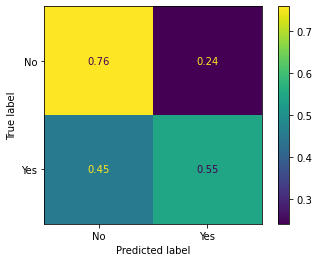

In [20]:
model = xgb.XGBClassifier()

pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

pipeline.fit(X_train, y_train, m__sample_weight=sample_weights)

evaluate_model(pipeline, X_valid, y_valid)

In [21]:
filename = 'app/model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

Model Scores for Validation Data:
--------------
Accuracy: 0.933
Precision: 0.342
Recall: 0.010
F1 score: 0.019
--------------
Confusion Matrix:


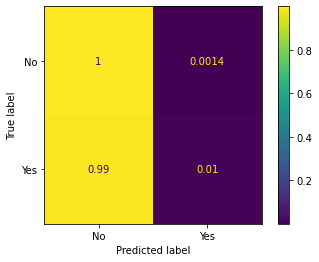

In [21]:
xgb_pipe1 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe1.fit(preprocessed_data, y_train)

evaluate_model(xgb_pipe1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.734
Precision: 0.130
Recall: 0.525
F1 score: 0.208
--------------
Confusion Matrix:


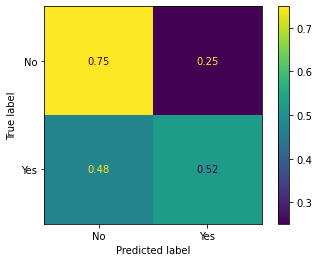

In [22]:
xgb_pipe2 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier(subsample=0.4, max_depth=15, alpha = 100))
])

xgb_pipe2.fit(preprocessed_data,
              y_train,
              my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe2, preprocessed_val_data, y_valid)

In [23]:
from collections import Counter
counter = Counter(y_train)
estimate = counter['No'] / counter['Yes']

Model Scores for Validation Data:
--------------
Accuracy: 0.748
Precision: 0.137
Recall: 0.525
F1 score: 0.217
--------------
Confusion Matrix:


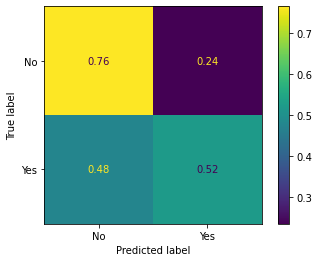

In [24]:
xgb_scaled_model = XGBClassifier(scale_pos_weight=estimate)
xgb_scaled_model.fit(preprocessed_data, y_train)

evaluate_model(xgb_scaled_model, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.702
Precision: 0.130
Recall: 0.610
F1 score: 0.214
--------------
Confusion Matrix:


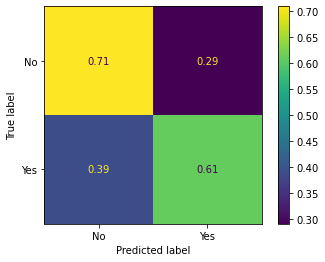

In [25]:
xgb_scaled_model2 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 4,
                                  eta = 0.2,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model2.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model2, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.717
Precision: 0.134
Recall: 0.597
F1 score: 0.219
--------------
Confusion Matrix:


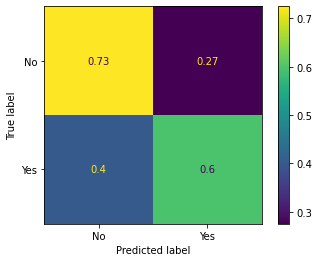

In [26]:
xgb_scaled_model3 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 6,
                                  eta = 0.1,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model3.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model3, preprocessed_val_data, y_valid)

### LightGBM

Model Scores for Validation Data:
--------------
Accuracy: 0.934
Precision: 0.571
Recall: 0.003
F1 score: 0.006
--------------
Confusion Matrix:


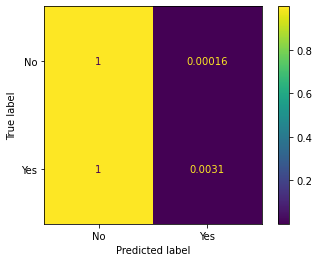

In [27]:
lgbm_model_1 = LGBMClassifier()

lgbm_model_1.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.692
Precision: 0.125
Recall: 0.603
F1 score: 0.206
--------------
Confusion Matrix:


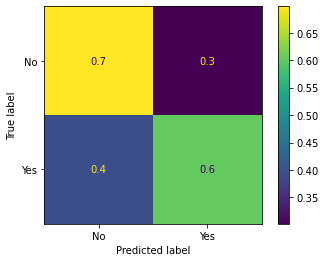

In [28]:
lgbm_model_2 = LGBMClassifier(scale_pos_weight=13,
                              learning_rate = 0.1,
                              num_leaves = 7,
                              max_depth = 3,
                              min_child_samples = 100,
                              max_bin = 100,
                              subsample = 0.7,
                              subsample_freq = 2,
                              colsample_bytree = 0.9,
                              min_child_weight = 0)

lgbm_model_2.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_2, preprocessed_val_data, y_valid)

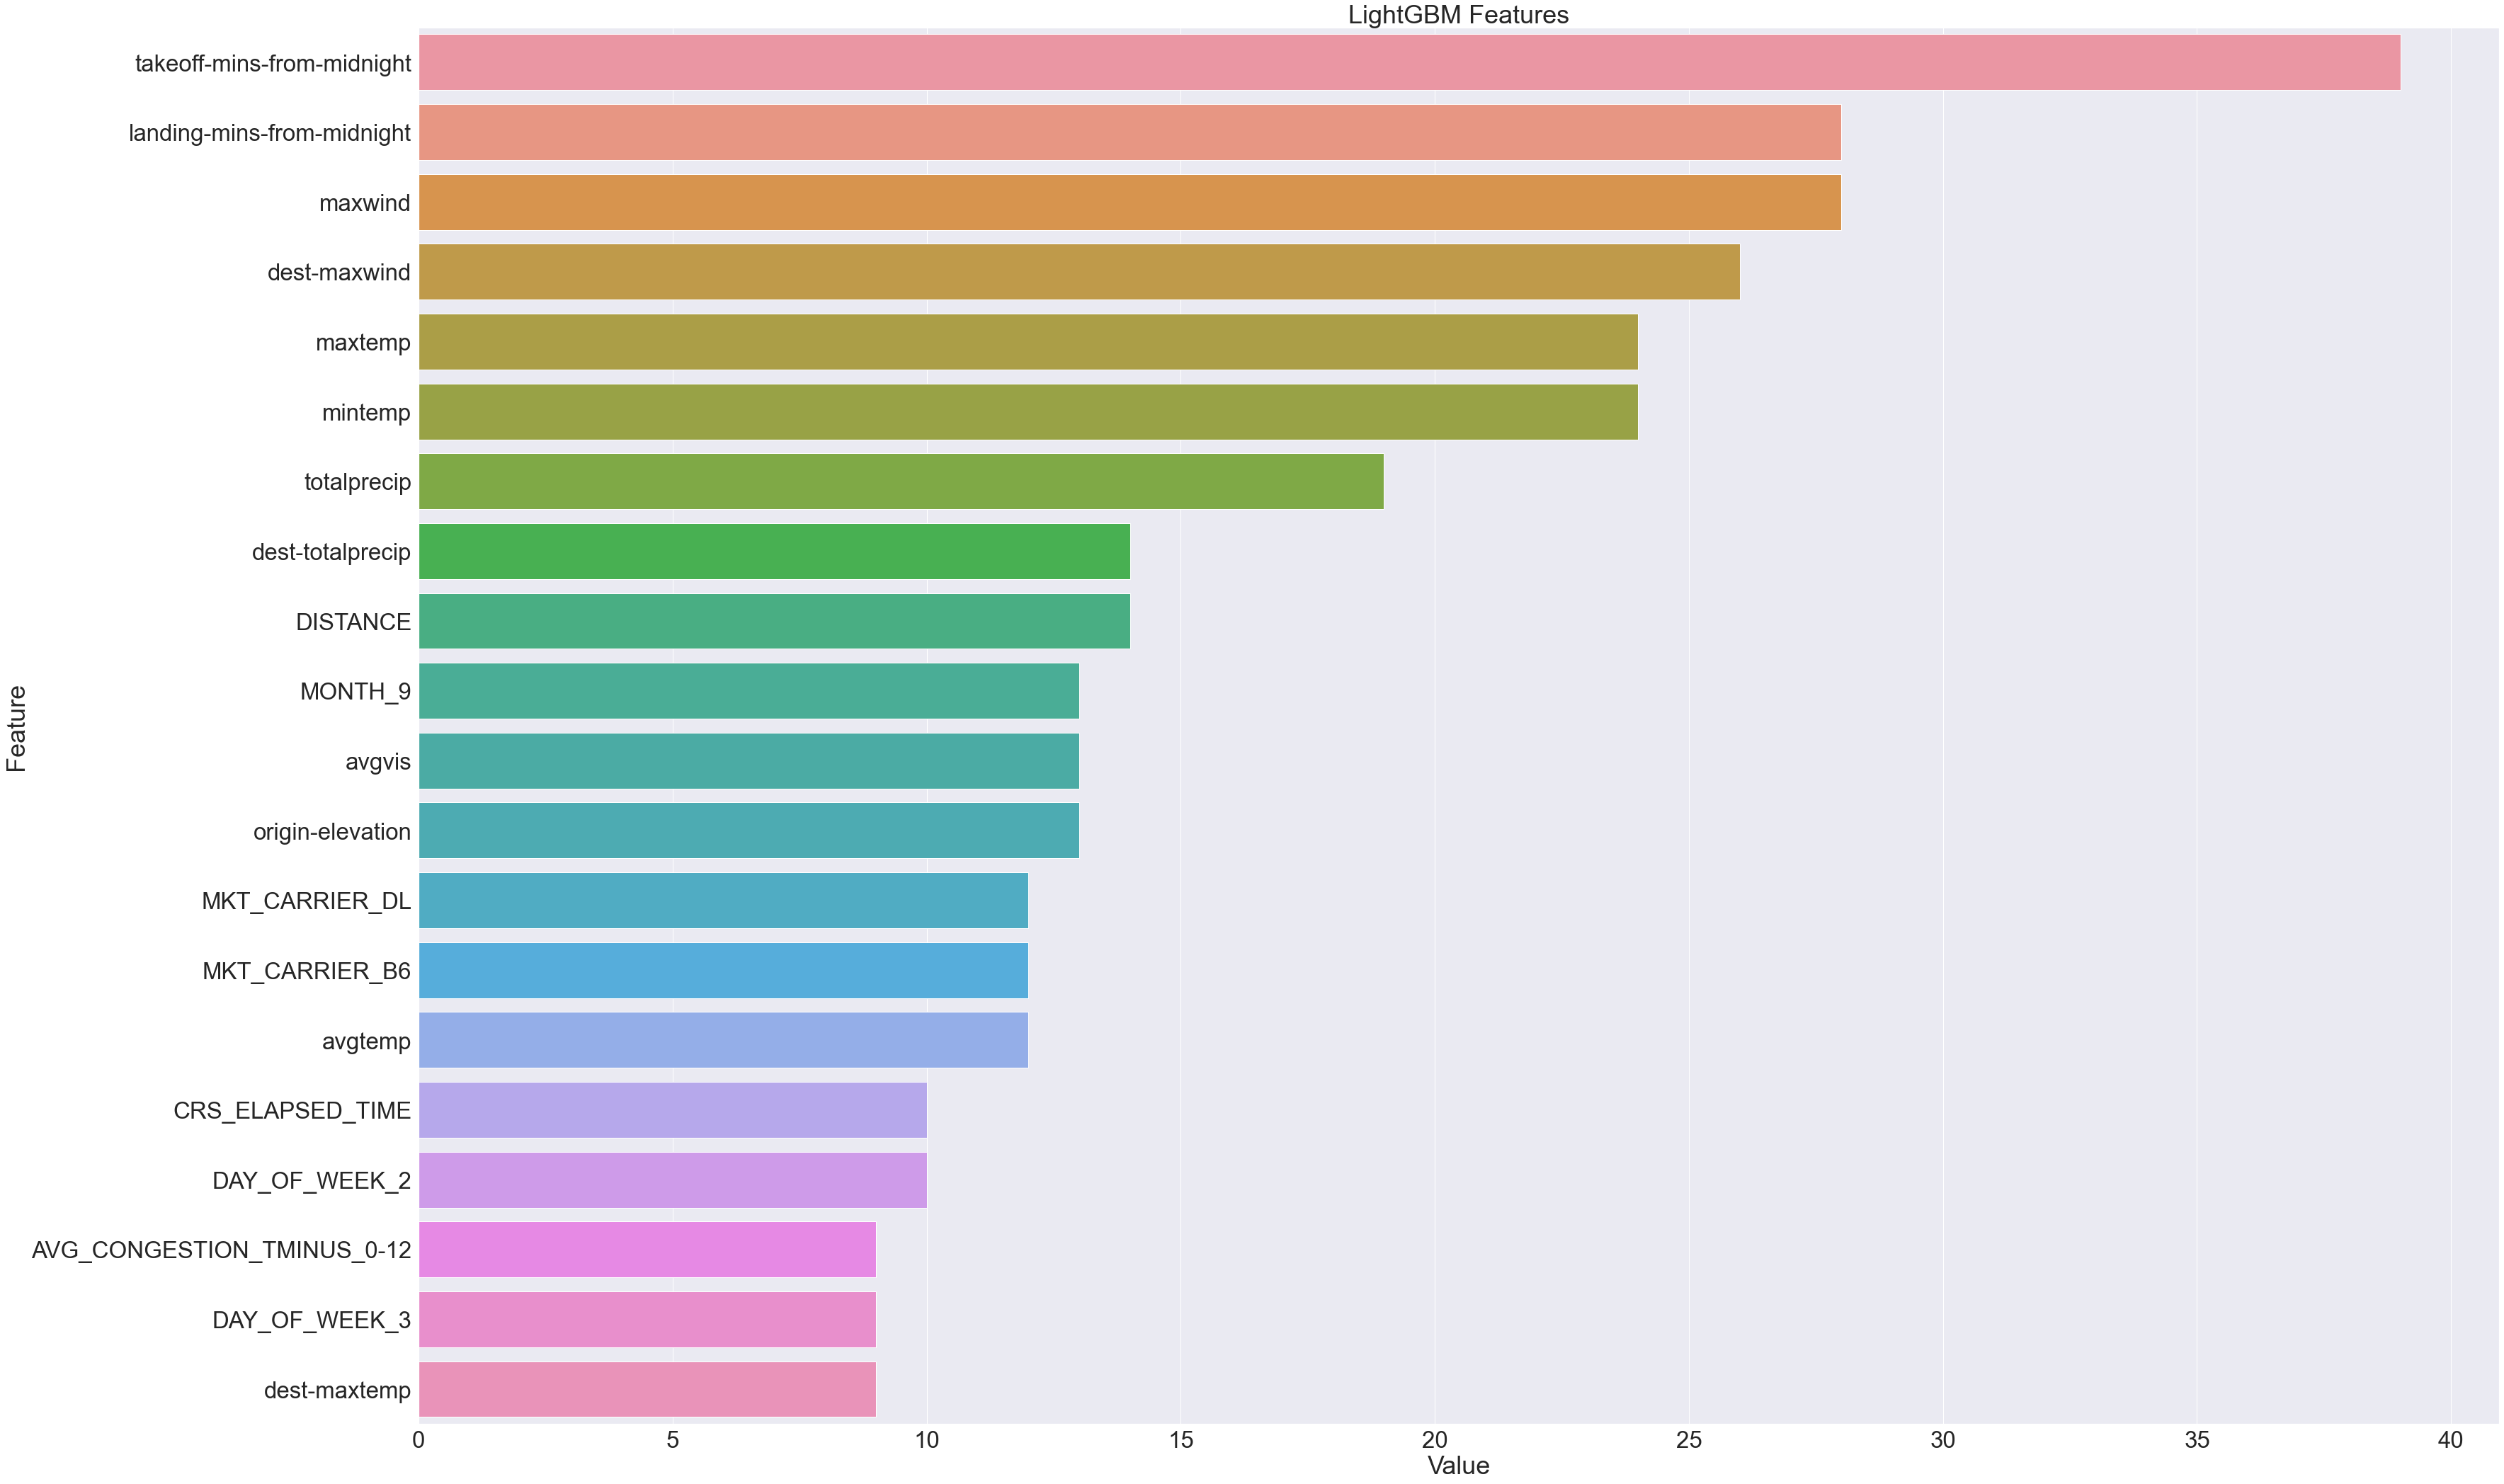

In [30]:
def plotImp(model, X , num = 20, fig_size = (50, 30)):
    boost = model.booster_
    feature_imp = pd.DataFrame({'Value':boost.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
    
plotImp(lgbm_model_2, preprocessed_data)

In [29]:
# Saving best performing model
# save the model to disk
filename = 'model.sav'
pickle.dump(xgb_pipe, open(filename, 'wb'))

### Deep Learning Models

In [153]:
dl_model_1 = Sequential()
dl_model_1.add(Dense(300, activation='relu', input_dim=n_features))
dl_model_1.add(Dense(150, activation='relu'))
dl_model_1.add(Dense(75, activation='relu'))
dl_model_1.add(Dense(30, activation='relu'))
dl_model_1.add(Dense(15, activation='relu'))
dl_model_1.add(Dense(1, activation='sigmoid'))

dl_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_results = dl_model_1.fit(preprocessed_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=25,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6235 - acc: 0.6984 - val_loss: 0.6083 - val_acc: 0.6646
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5953 - acc: 0.7124 - val_loss: 0.5319 - val_acc: 0.7584
Epoch 3/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5783 - acc: 0.6920 - val_loss: 0.6787 - val_acc: 0.6722
Epoch 4/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5481 - acc: 0.7247 - val_loss: 0.5842 - val_acc: 0.7160
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5052 - acc: 0.7263 - val_loss: 0.5990 - val_acc: 0.6993
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.4506 - acc: 0.7562 - val_loss: 0.6148 - val_acc: 0.6615
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.3958 - acc: 0.7807 - val_loss: 0.5291 - val_acc: 0.7420
Epoch 8/25
2428/2428 [==============================] - 4s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.868
Precision: 0.144
Recall: 0.264
F1 score: 0.186
--------------
Confusion Matrix:


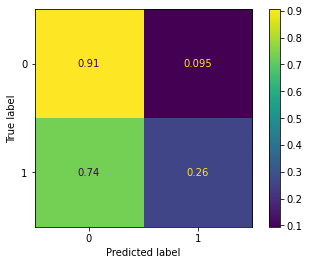

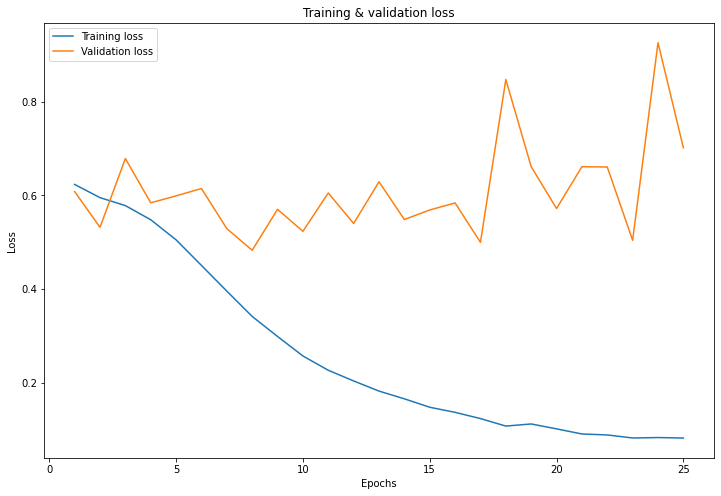

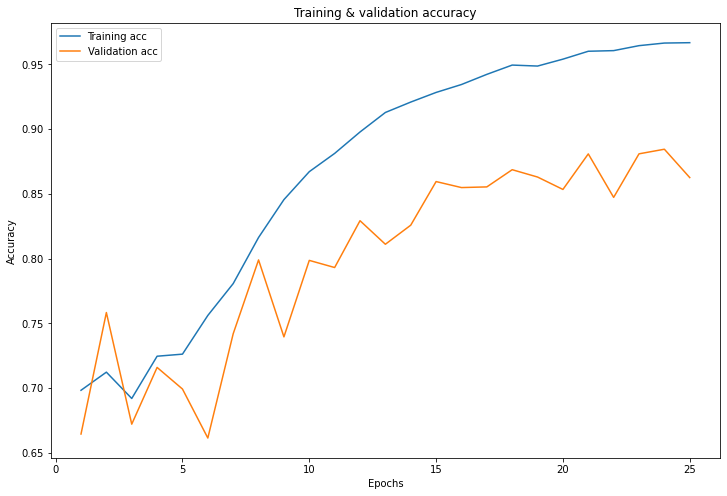

In [311]:
# Evaluate Results
evaluate_model(dl_model_1, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_1_results)

In [171]:
dl_model_1_poly = Sequential()
dl_model_1_poly.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly.add(Dense(150, activation='relu'))
dl_model_1_poly.add(Dense(75, activation='relu'))
dl_model_1_poly.add(Dense(30, activation='relu'))
dl_model_1_poly.add(Dense(15, activation='relu'))
dl_model_1_poly.add(Dense(1, activation='sigmoid'))

dl_model_1_poly.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_results = dl_model_1_poly.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=50,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/50
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6335 - acc: 0.6623 - val_loss: 0.5814 - val_acc: 0.6650
Epoch 2/50
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6174 - acc: 0.6741 - val_loss: 0.6444 - val_acc: 0.7016
Epoch 3/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6019 - acc: 0.6971 - val_loss: 0.5936 - val_acc: 0.6764
Epoch 4/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5942 - acc: 0.6957 - val_loss: 0.6409 - val_acc: 0.6746
Epoch 5/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5838 - acc: 0.6993 - val_loss: 0.6618 - val_acc: 0.5864
Epoch 6/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5760 - acc: 0.7005 - val_loss: 0.6383 - val_acc: 0.6715
Epoch 7/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5708 - acc: 0.7060 - val_loss: 0.5445 - val_acc: 0.7240
Epoch 8/50
2428/2428 [==============================] - 6s 3ms

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.143
Recall: 0.212
F1 score: 0.171
--------------
Confusion Matrix:


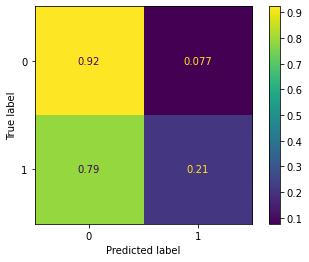

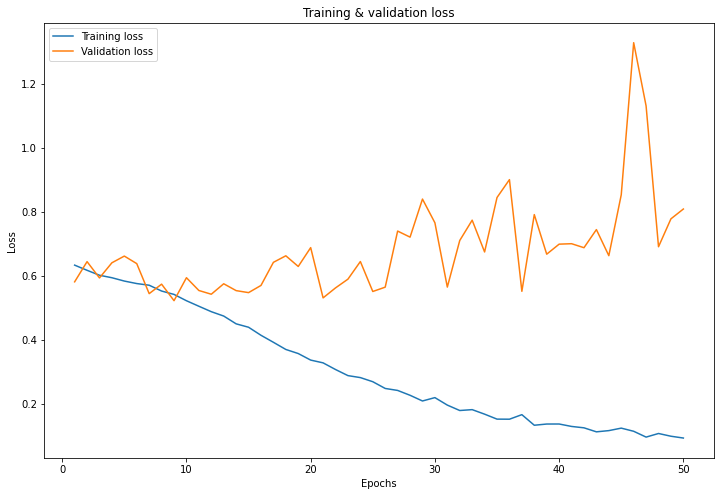

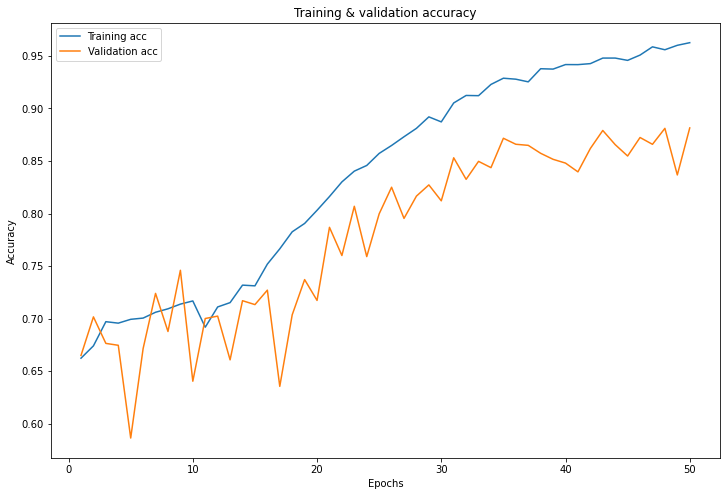

In [312]:
# Evaluate Results
evaluate_model(dl_model_1_poly, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_results)

In [155]:
dl_model_2 = Sequential()
dl_model_2.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_2.add(Dense(150, activation='relu'))
dl_model_2.add(Dense(75, activation='relu'))
dl_model_2.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_2.add(Dense(15, activation='relu'))
dl_model_2.add(Dense(1, activation='sigmoid'))

dl_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_2_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=25,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6894 - acc: 0.6916 - val_loss: 0.6831 - val_acc: 0.6039
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6327 - acc: 0.6999 - val_loss: 0.6490 - val_acc: 0.6772
Epoch 3/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6253 - acc: 0.7035 - val_loss: 0.7051 - val_acc: 0.6093
Epoch 4/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6183 - acc: 0.7031 - val_loss: 0.6793 - val_acc: 0.6714
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6149 - acc: 0.7166 - val_loss: 0.6100 - val_acc: 0.7405
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6114 - acc: 0.7237 - val_loss: 0.6378 - val_acc: 0.7014
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6105 - acc: 0.7210 - val_loss: 0.5521 - val_acc: 0.7242
Epoch 8/25
2428/2428 [==============================] - 5s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.723
Precision: 0.101
Recall: 0.486
F1 score: 0.167
--------------
Confusion Matrix:


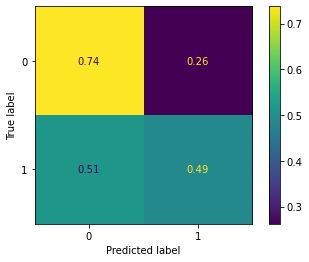

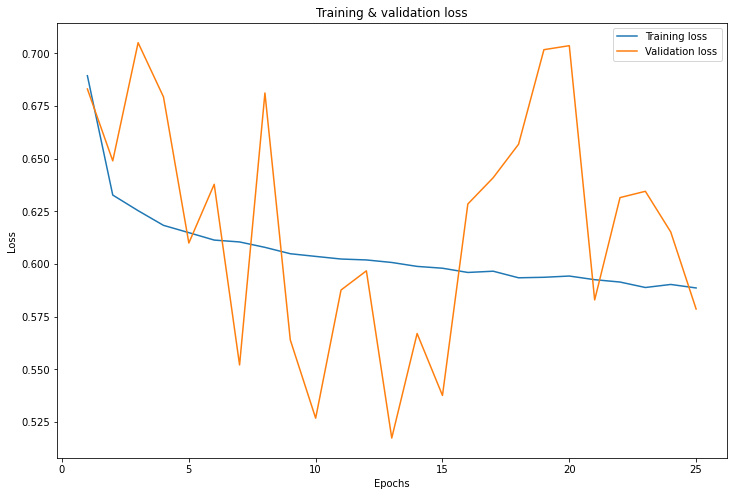

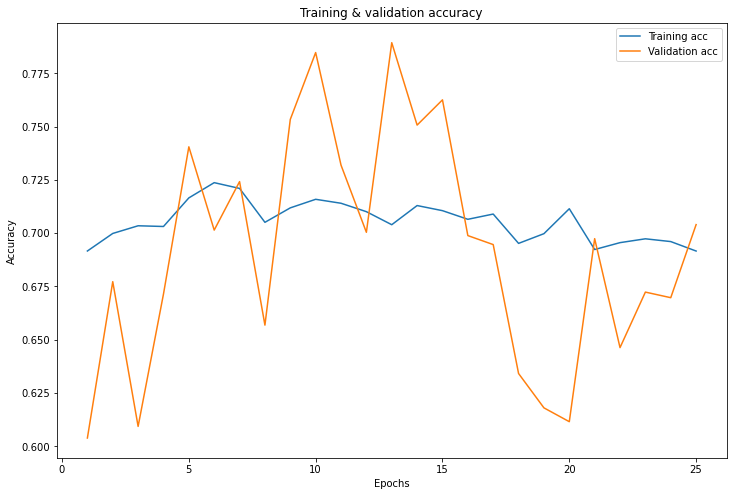

In [313]:
# Evaluate Results
evaluate_model(dl_model_2, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_2_results)

In [206]:
dl_model_3 = Sequential()
dl_model_3.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_3.add(Dense(150, activation='relu'))
dl_model_3.add(Dense(75, activation='relu'))
dl_model_3.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_3.add(Dense(15, activation='relu'))
dl_model_3.add(Dense(1, activation='sigmoid'))

dl_model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_3_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=100,
                           batch_size=100,
                           validation_split=0.2)

Epoch 1/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5617 - acc: 0.7078 - val_loss: 0.6077 - val_acc: 0.6797
Epoch 2/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5560 - acc: 0.6976 - val_loss: 0.5948 - val_acc: 0.6942
Epoch 3/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5530 - acc: 0.6952 - val_loss: 0.6282 - val_acc: 0.6599
Epoch 4/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5490 - acc: 0.6897 - val_loss: 0.6134 - val_acc: 0.6612
Epoch 5/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5467 - acc: 0.6850 - val_loss: 0.6135 - val_acc: 0.6730
Epoch 6/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5446 - acc: 0.6875 - val_loss: 0.6310 - val_acc: 0.6323
Epoch 7/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5423 - acc: 0.6840 - val_loss: 0.6065 - val_acc: 0.6424
Epoch 8/100
777/777 [==============================] - 3s 3ms/step - 

380/380 [==============================] - 1s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.101
Precision: 0.056
Recall: 0.925
F1 score: 0.105
--------------
Confusion Matrix:


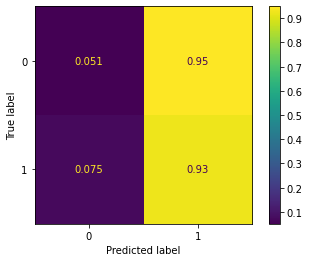

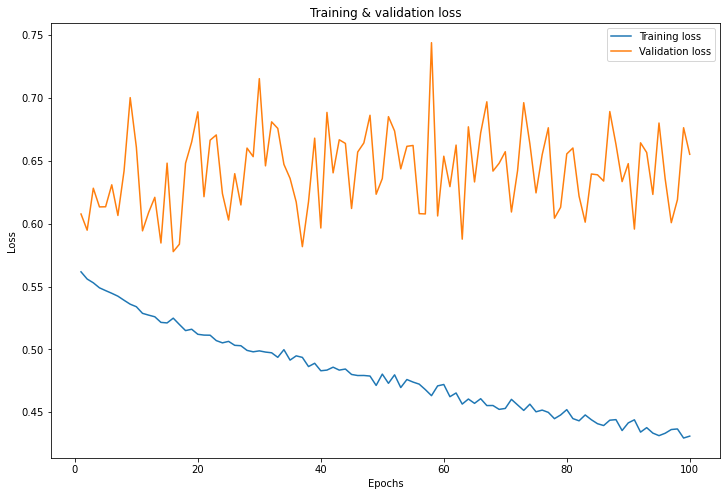

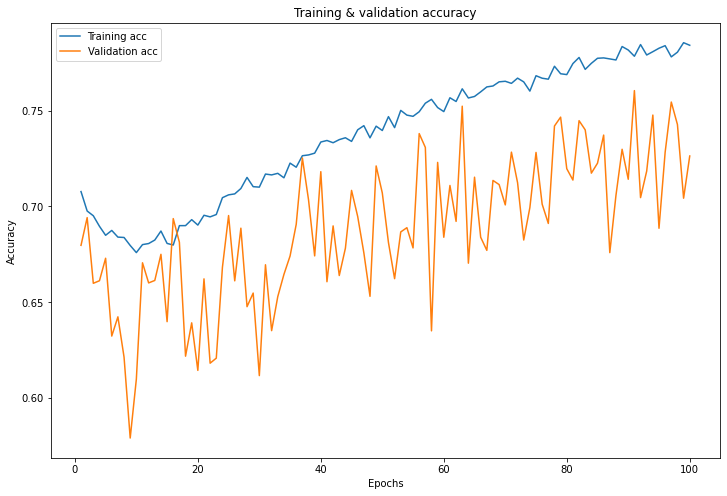

In [314]:
# Evaluate Results
evaluate_model(dl_model_3, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_3_results)

In [175]:
dl_model_1_poly_2 = Sequential()
dl_model_1_poly_2.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2.add(Dense(150, activation='relu'))
dl_model_1_poly_2.add(Dense(75, activation='relu'))
dl_model_1_poly_2.add(Dense(30, activation='relu'))
dl_model_1_poly_2.add(Dense(15, activation='relu'))
dl_model_1_poly_2.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_results = dl_model_1_poly_2.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6391 - acc: 0.6488 - val_loss: 0.6745 - val_acc: 0.6418
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6177 - acc: 0.6784 - val_loss: 0.6295 - val_acc: 0.6760
Epoch 3/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6036 - acc: 0.6890 - val_loss: 0.6816 - val_acc: 0.6552
Epoch 4/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5950 - acc: 0.6759 - val_loss: 0.5557 - val_acc: 0.6124
Epoch 5/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5895 - acc: 0.6895 - val_loss: 0.6212 - val_acc: 0.6540
Epoch 6/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5768 - acc: 0.6908 - val_loss: 0.5617 - val_acc: 0.7153
Epoch 7/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5678 - acc: 0.6949 - val_loss: 0.6035 - val_acc: 0.6932
Epoch 8/100
2428/2428 [==============================] 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.124
Recall: 0.171
F1 score: 0.144
--------------
Confusion Matrix:


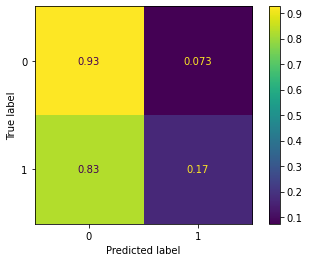

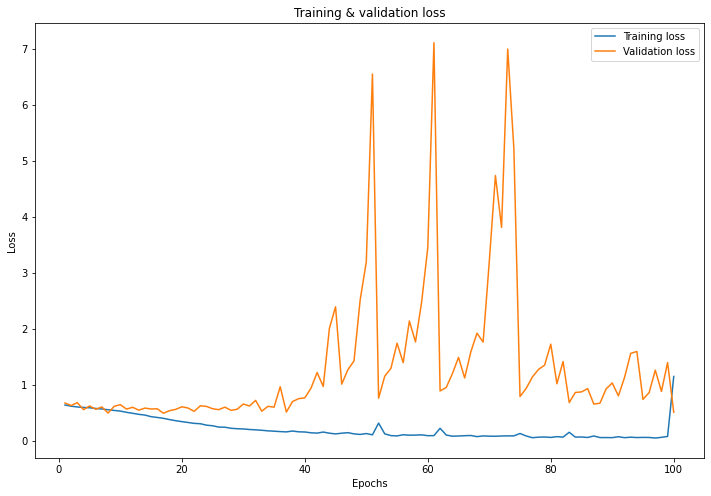

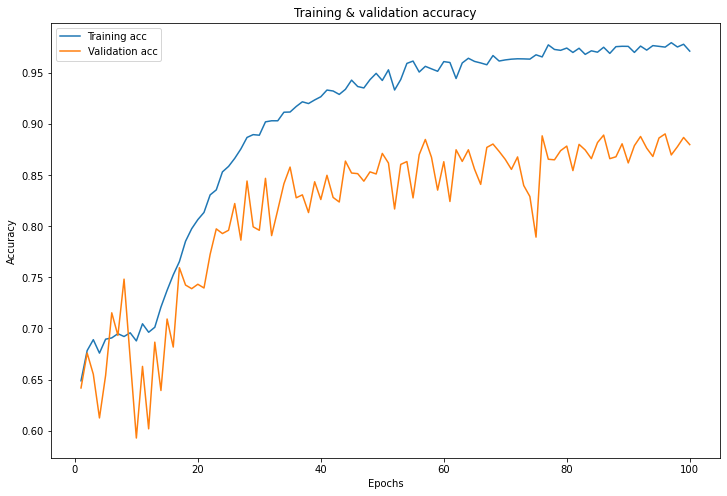

In [315]:
# Evaluate Results
evaluate_model(dl_model_1_poly_2, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_results)

In [178]:
dl_model_1_poly_2_reg = Sequential()
dl_model_1_poly_2_reg.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(150, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(75, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(30, activation='relu'))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(15, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2_reg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_reg_results = dl_model_1_poly_2_reg.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6501 - acc: 0.6505 - val_loss: 0.5360 - val_acc: 0.8054
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6301 - acc: 0.6979 - val_loss: 0.6074 - val_acc: 0.6998
Epoch 3/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6205 - acc: 0.6994 - val_loss: 0.6233 - val_acc: 0.6852
Epoch 4/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6120 - acc: 0.6962 - val_loss: 0.5841 - val_acc: 0.7371
Epoch 5/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6082 - acc: 0.6927 - val_loss: 0.5063 - val_acc: 0.7646
Epoch 6/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6054 - acc: 0.6878 - val_loss: 0.5105 - val_acc: 0.8449
Epoch 7/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6024 - acc: 0.6800 - val_loss: 0.5685 - val_acc: 0.6912
Epoch 8/100
2428/2428 [==============================] 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.147
Recall: 0.248
F1 score: 0.185
--------------
Confusion Matrix:


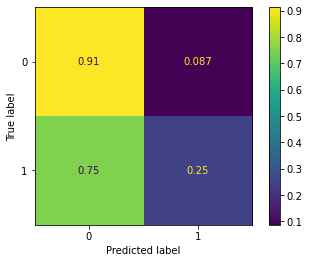

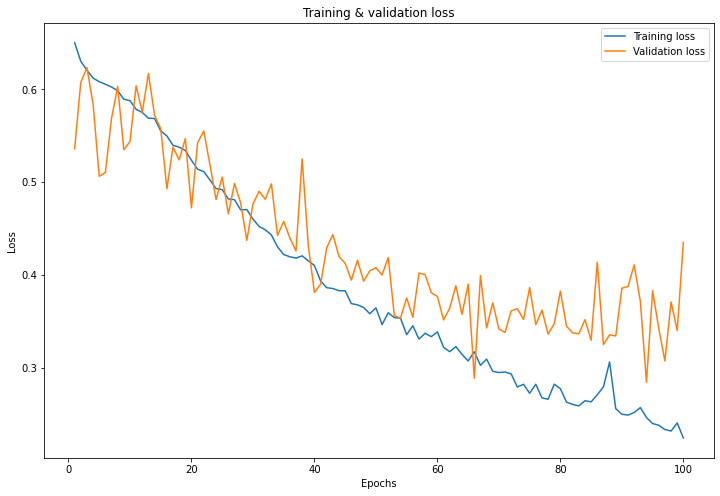

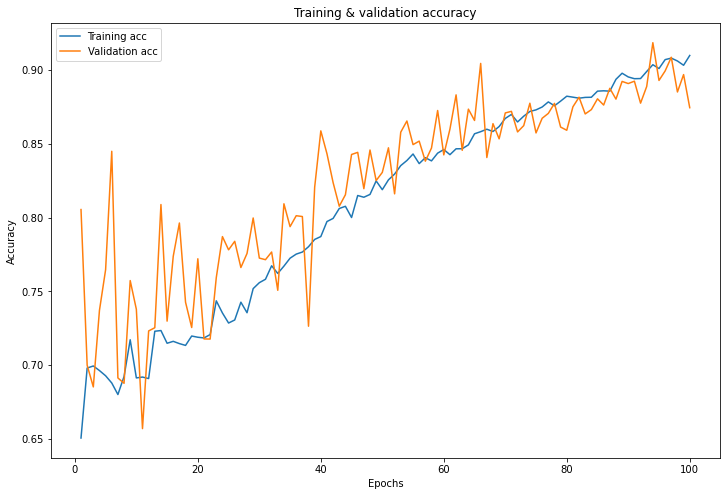

In [316]:
evaluate_model(dl_model_1_poly_2_reg, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_reg_results)

380/380 [==============================] - 1s 2ms/step


Text(0, 0.5, 'Number of Predictions')

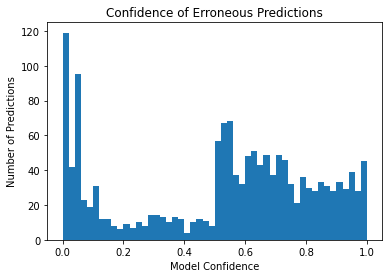

In [318]:
preds = dl_model_1_poly_2_reg.predict(preprocessed_poly2_val_data)
preds_int = np.zeros((preprocessed_poly2_val_data.shape[0] , 1))
for i in range(preds_int.shape[0]):
    if preds[i,0] > 0.5: 
        preds_int[i, 0] = 1
    else:
        preds_int[i, 0] = 0

wrong_predictions = []

for i in range(preds.shape[0]):
    if preds_int[i, 0] == valid_labels[i,0]: 
        pass
    else:
        wrong_predictions.append(preds[i,0])

# matplotlib histogram
plt.hist(wrong_predictions, bins = 50)
plt.title('Confidence of Erroneous Predictions')
plt.xlabel('Model Confidence')
plt.ylabel('Number of Predictions')

Looks like the model pretty uniformly struggles with predicting positive cases, and there is a big number instances (200+) where the model is almost confident there will be no delay and there is.

In [204]:
dl_model_1_poly_3 = Sequential()
dl_model_1_poly_3.add(Dense(2900, activation='relu', input_dim=n_features_poly3))
dl_model_1_poly_3.add(Dense(1500, activation='relu'))
dl_model_1_poly_3.add(Dense(750, activation='relu'))
dl_model_1_poly_3.add(Dense(250, activation='relu'))
dl_model_1_poly_3.add(Dense(100, activation='relu'))
dl_model_1_poly_3.add(Dense(50, activation='relu'))
dl_model_1_poly_3.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_3_results = dl_model_1_poly_3.fit(preprocessed_poly3_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=1000,
                                    validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 15s 186ms/step - loss: 0.6771 - acc: 0.6536 - val_loss: 0.6478 - val_acc: 0.6807
Epoch 2/100
78/78 [==============================] - 11s 147ms/step - loss: 0.6234 - acc: 0.6882 - val_loss: 0.7430 - val_acc: 0.5528
Epoch 3/100
78/78 [==============================] - 13s 164ms/step - loss: 0.6184 - acc: 0.6754 - val_loss: 0.5305 - val_acc: 0.7515
Epoch 4/100
78/78 [==============================] - 12s 159ms/step - loss: 0.6099 - acc: 0.6819 - val_loss: 0.6014 - val_acc: 0.6494
Epoch 5/100
78/78 [==============================] - 13s 162ms/step - loss: 0.6051 - acc: 0.6958 - val_loss: 0.5780 - val_acc: 0.6919
Epoch 6/100
78/78 [==============================] - 13s 163ms/step - loss: 0.5988 - acc: 0.6882 - val_loss: 0.7075 - val_acc: 0.6381
Epoch 7/100
78/78 [==============================] - 13s 161ms/step - loss: 0.5925 - acc: 0.7063 - val_loss: 0.6684 - val_acc: 0.6386
Epoch 8/100
78/78 [==============================] - 13s 161ms

Epoch 62/100
78/78 [==============================] - 12s 150ms/step - loss: 0.1653 - acc: 0.9103 - val_loss: 0.8679 - val_acc: 0.8364
Epoch 63/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1750 - acc: 0.9062 - val_loss: 0.6383 - val_acc: 0.8203
Epoch 64/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1872 - acc: 0.8986 - val_loss: 0.6922 - val_acc: 0.8154
Epoch 65/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1633 - acc: 0.9140 - val_loss: 0.8325 - val_acc: 0.8321
Epoch 66/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1763 - acc: 0.9083 - val_loss: 0.6843 - val_acc: 0.8358
Epoch 67/100
78/78 [==============================] - 12s 151ms/step - loss: 0.1503 - acc: 0.9219 - val_loss: 0.7412 - val_acc: 0.8334
Epoch 68/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1340 - acc: 0.9254 - val_loss: 0.7996 - val_acc: 0.8528
Epoch 69/100
78/78 [==============================] - 1

380/380 [==============================] - 4s 11ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.121
Recall: 0.187
F1 score: 0.147
--------------
Confusion Matrix:


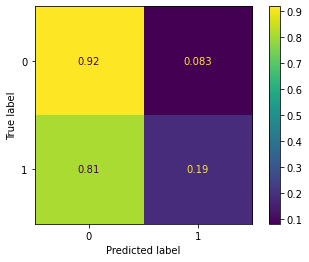

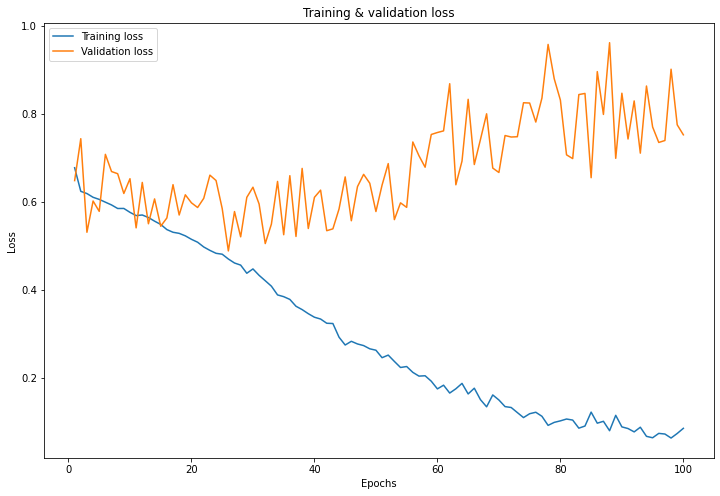

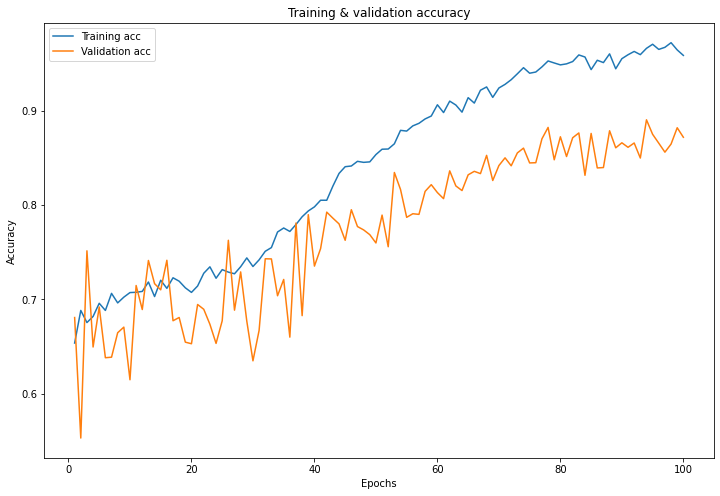

In [317]:
evaluate_model(dl_model_1_poly_3, preprocessed_poly3_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_3_results)